Input the name/path of the file that you would like to plot using pretty-plot as `marslab_file`.

In [1]:
from pretty_plot.cli import do_pplot

marslab_file = 'pretty_plot/data/zcam/fakeIOFspectra-marslab.csv'

The function `do_pplot` is the simipliest way to use pretty plot. If you've used the pretty plot cli (from a terminal/command line), this is the function that is being called there. With the box below we will plot a default pretty plot from the file you specified above. `do_pplot` can also take a folder path instead of a path to a marslab file. If a folder is passed it will make pretty plots from all of the marslab files it can find in that folder. If you pass `recursive=True` it will make pretty plots from all of the marslab files it can find in that folder and folders within that folder.

Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


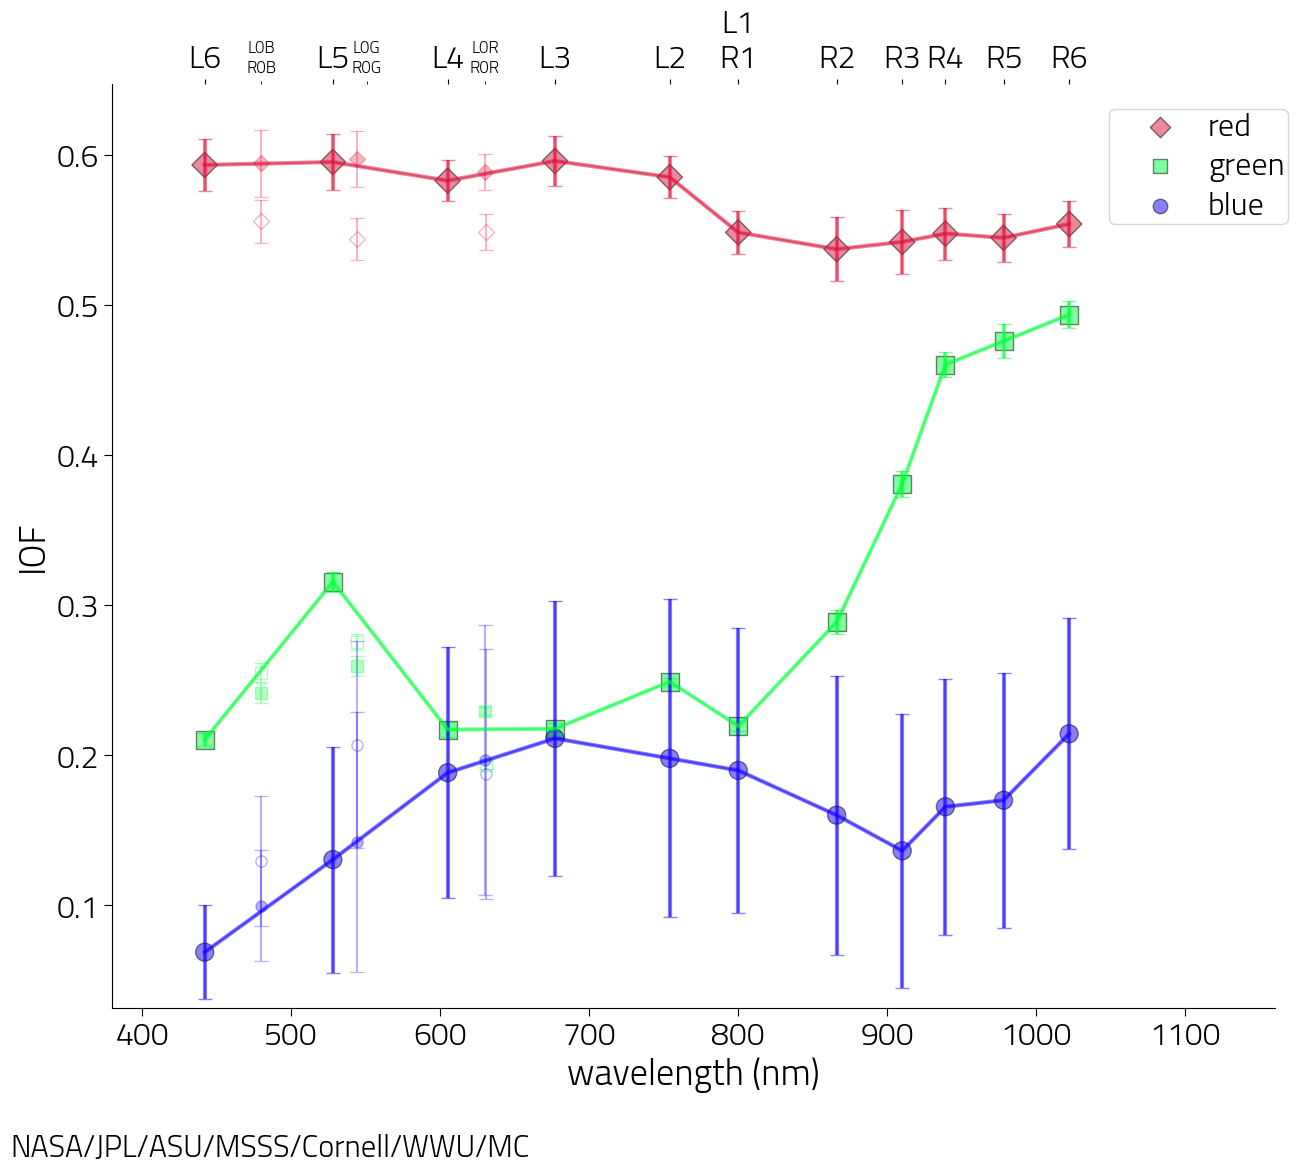

In [2]:
# Below you can see the default pretty plot for your marslab file
# A .png of this plot was saved to the same directory as the initial marslab file

do_pplot(marslab_file)


Now, that might seem a bit squished and difficult to interpret with all the overlapping spectra. Let's explore the `offset` option pretty-plot now has. `offset` can be either a single number or a list of numbers. The single number will offset each spectra by that amount from the last one. A list of offsets will apply the given absolute (not additive) offset value to each ROI in the file. The offset list must be the same length as the number of spectra in the file or you will receive an error.

Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


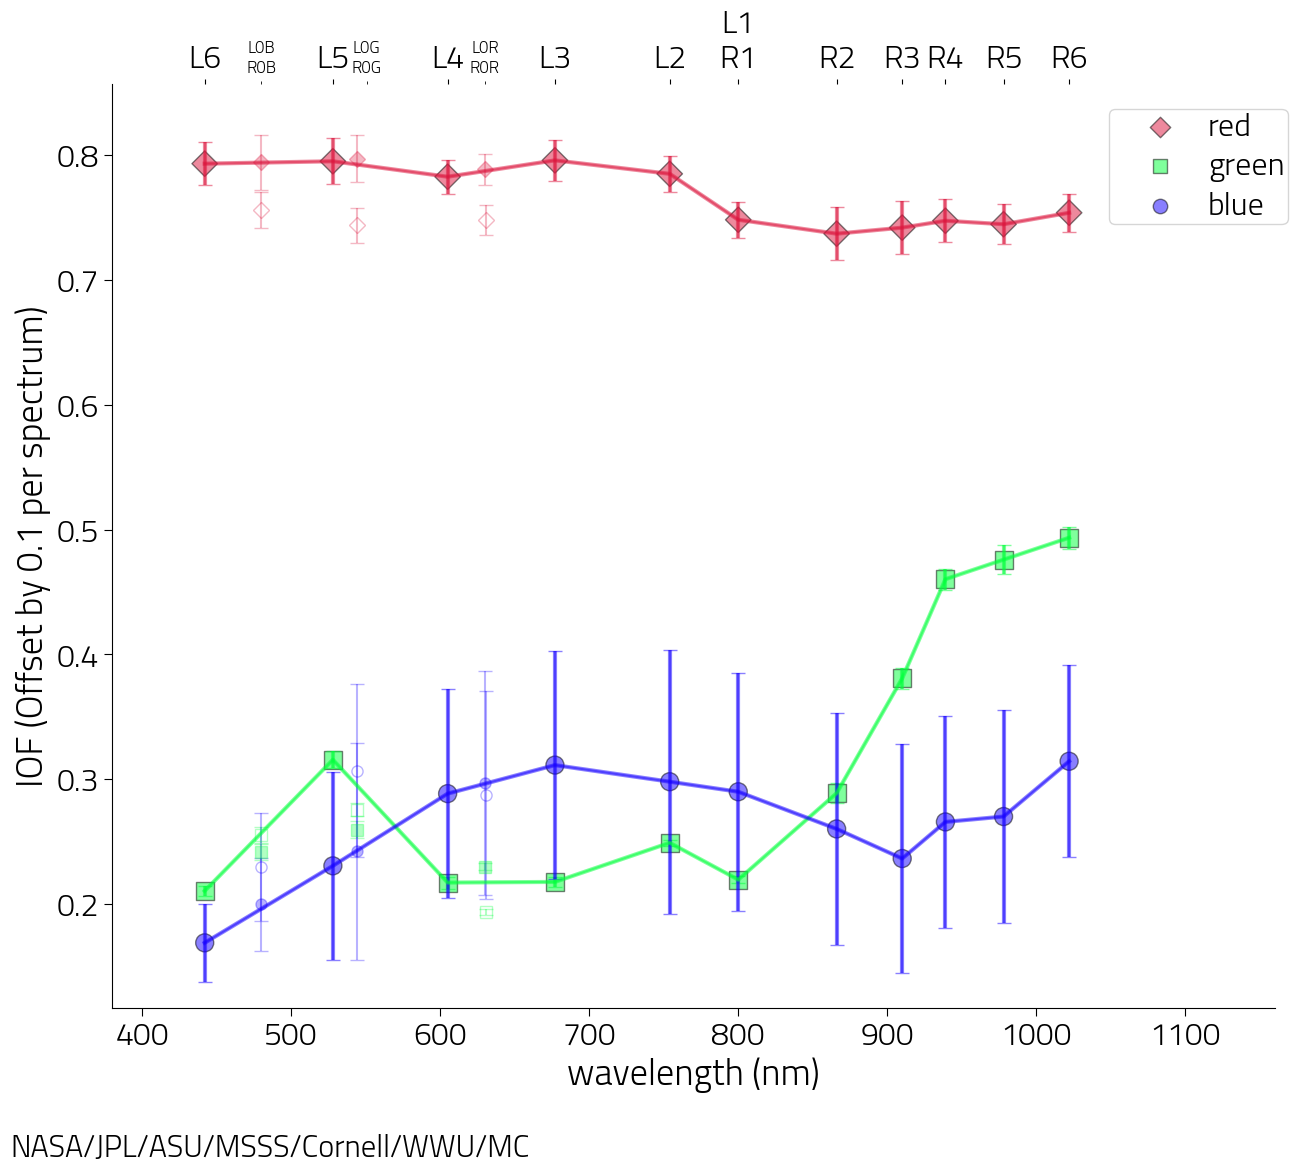

In [3]:
# an example with a set offset, this will usually be a good choice for similar spectra

do_pplot(marslab_file, offset=0.1)


Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


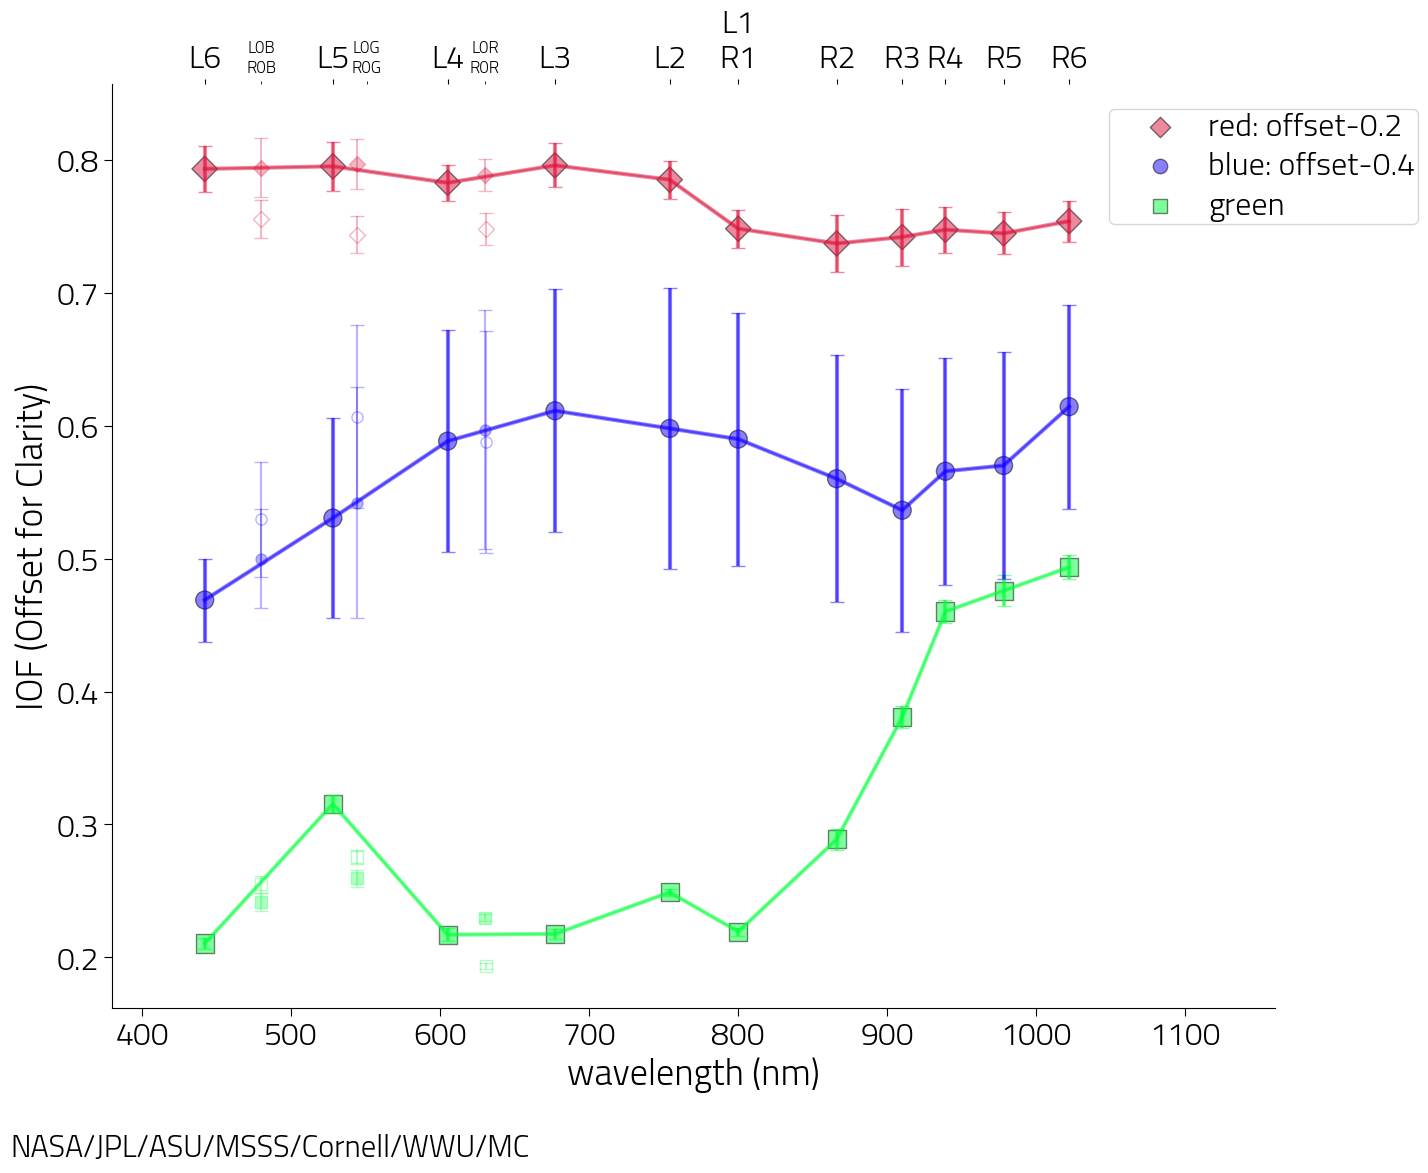

In [4]:
# formatted example for a list of offsets; this is most helpful when the spectra are very different

# You'll need to change the number of values in the offset list to equal the number of spectra in your file!!

do_pplot(marslab_file, offset=[0, 0.4, 0.2])


If you'd like to ignore the bayer filters entirely (not have them plot) you can use `plt_bayer = False`

Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


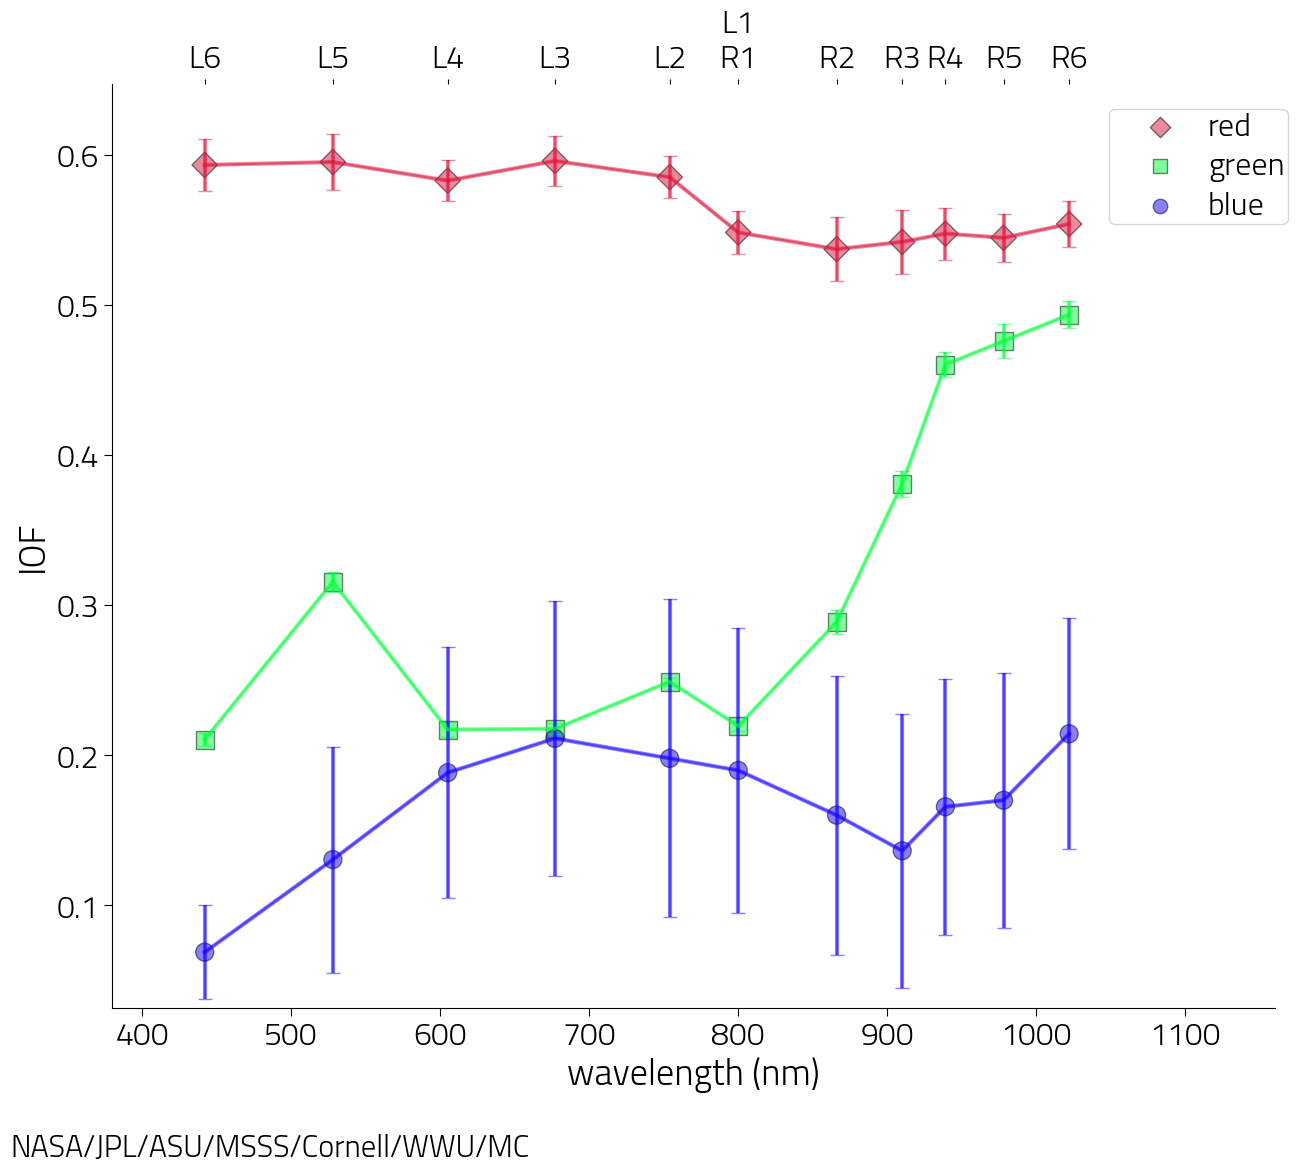

In [5]:
do_pplot(marslab_file, plt_bayer=False)

If you'd like change the values shown in the legend you can use the `roi_labels` feature to specify the names you'd like plotted for each. The values for the roi_labels should be given in the same order your ROIs appear in your marslab file.

**There needs to be the same number of values in roi_labels as there are ROIs!**

Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


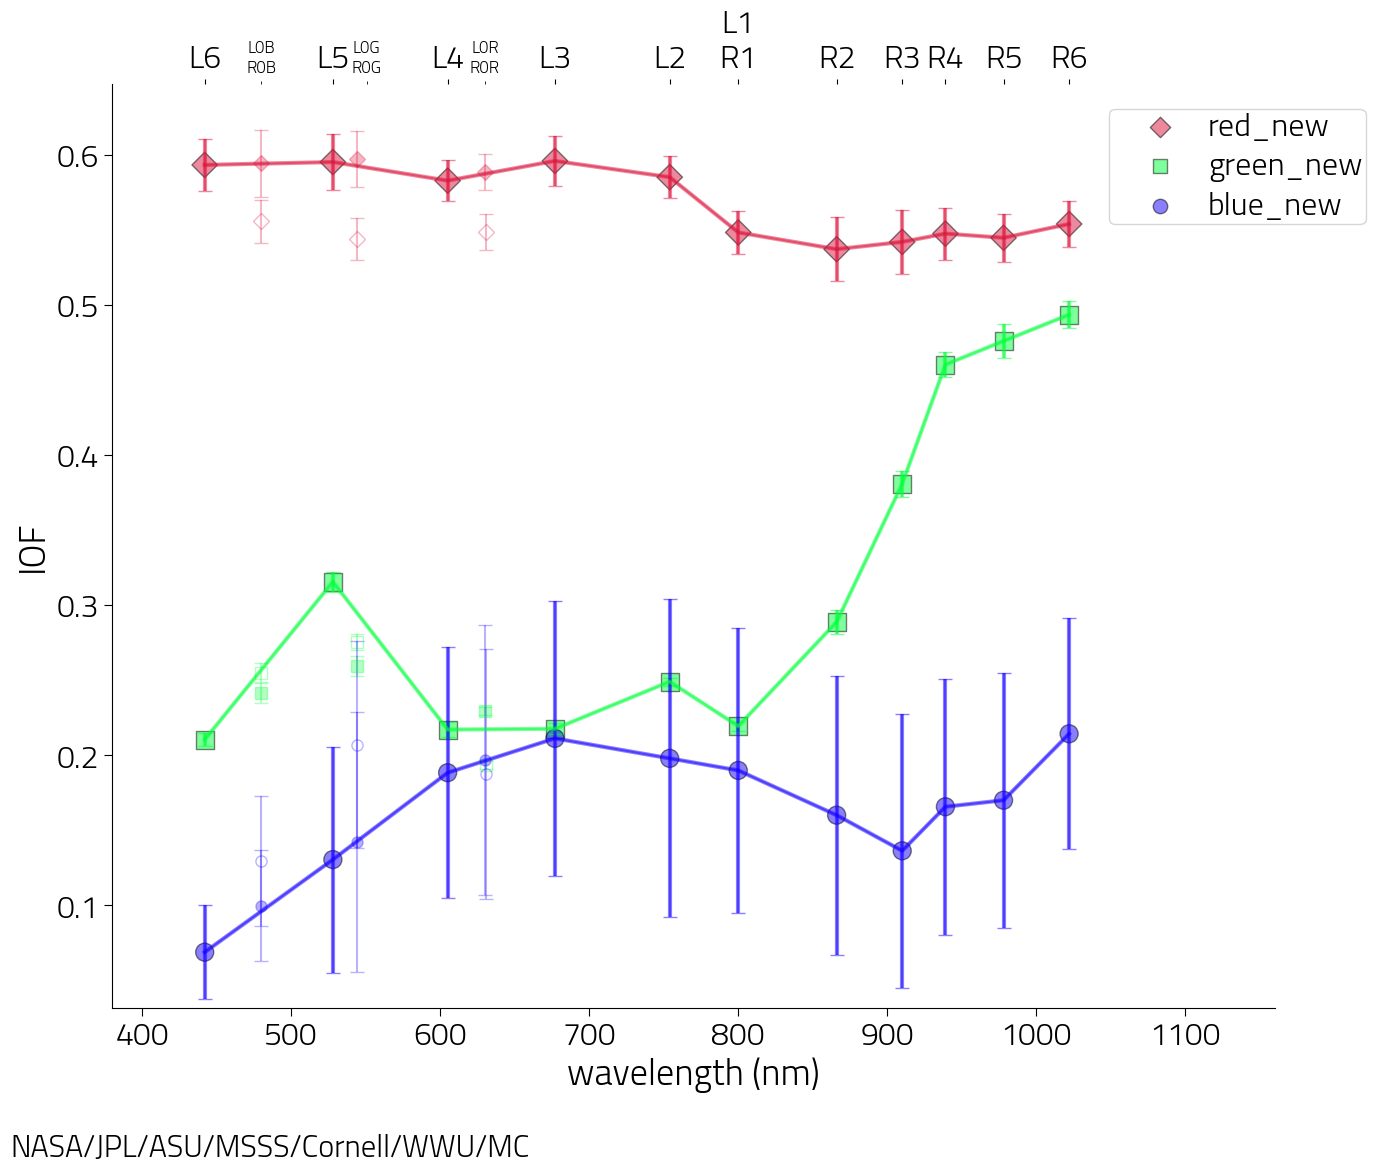

In [11]:
do_pplot(marslab_file, roi_labels=["green_new", "blue_new", "red_new"])

Want to plot ROIs from multiple different observations on one pretty plot? You can create a new marslab file with `merge_and_drop` and pass that new csv to `do_pplot`. With `merge_and_drop` you can either specify which rois to drop or which rois to keep using `colors_to_drop` and `colors_to_keep`. 

If you don't want to drop rois for a given file pass an empty list when using `colors_to_drop` for that file. In the example below we would not drop any ROIs from our second file.

If you'd like to keep a copy of this concatenated marslab file specify an output name using `output_fn` = filename in the `merge_and_drop` function call. Otherwise your file will be named `marslab_concatenated.csv`

**If you use a concatenated marslab file make sure you include an annotation on your pretty plot call, the default annotation will pull only from the information in the first row otherwise!**

Writing marslab_concatenated.csv
Writing marslab_concatenated.png


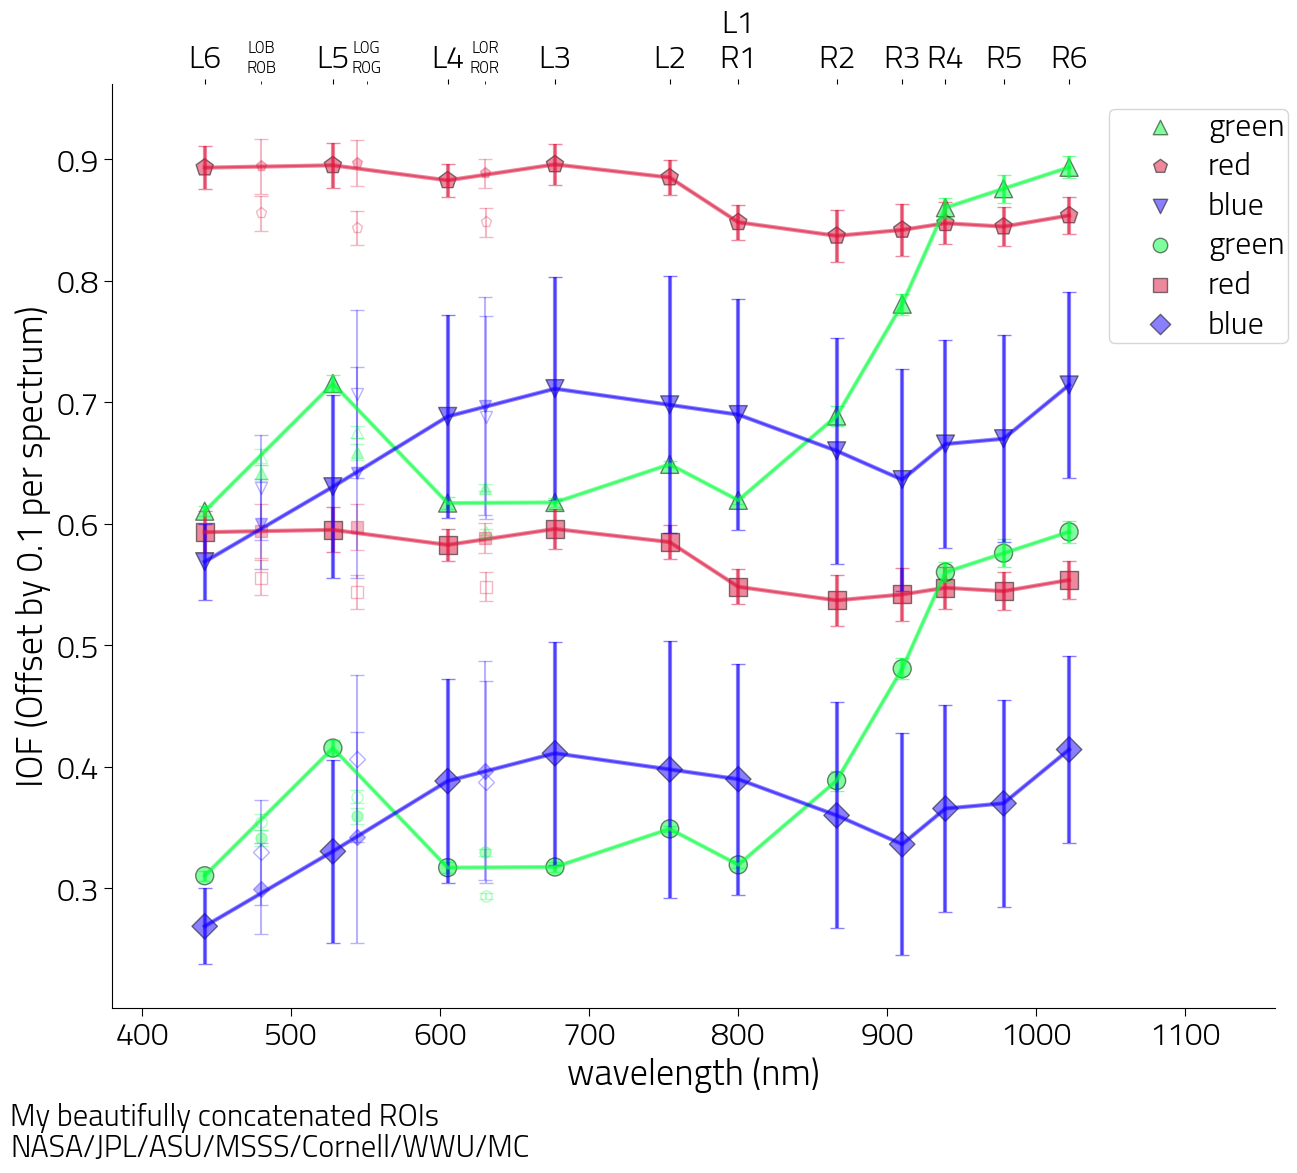

In [7]:
from pretty_plot.pplot_utils import merge_and_drop
from pretty_plot.cli import do_pplot

# list of paths of marslab files to concatenate (these should all be different files; this is just an example)

files_to_merge = ['pretty_plot/data/zcam/fakeIOFspectra-marslab.csv',
                  'pretty_plot/data/zcam/fakeIOFspectra-marslab.csv',
                  'pretty_plot/data/zcam/fakeIOFspectra-marslab.csv']

# `colors_to_drop` will need to be a list the length of the number of files you are merging.
# In this case we are dropping the green and blue ROI from the first file, not dropping any from 
# the second file and dropping the red ROI in the third file.

colors_to_drop = [["green", "blue"], [], ["red"]]

concatenated_marslab_file = merge_and_drop(files_to_merge, colors_to_drop=colors_to_drop)

do_pplot(concatenated_marslab_file, offset=0.1, annotation="My beautifully concatenated ROIs")

If you use an offset on the spectra it can flatten them out and remove spectral contrast. To combat this you can use the `width_sf` and `height_sf` to apply scale factors to the axes. Currently, this feature is experimental and has not been optimized (e.g. fonts may squish into each other). You may find that lengthening the y-axis may work better than shortening the x-axis or vice versa. An example is below.

Writing pretty_plot/data/zcam/fakeIOFspectra-marslab.png


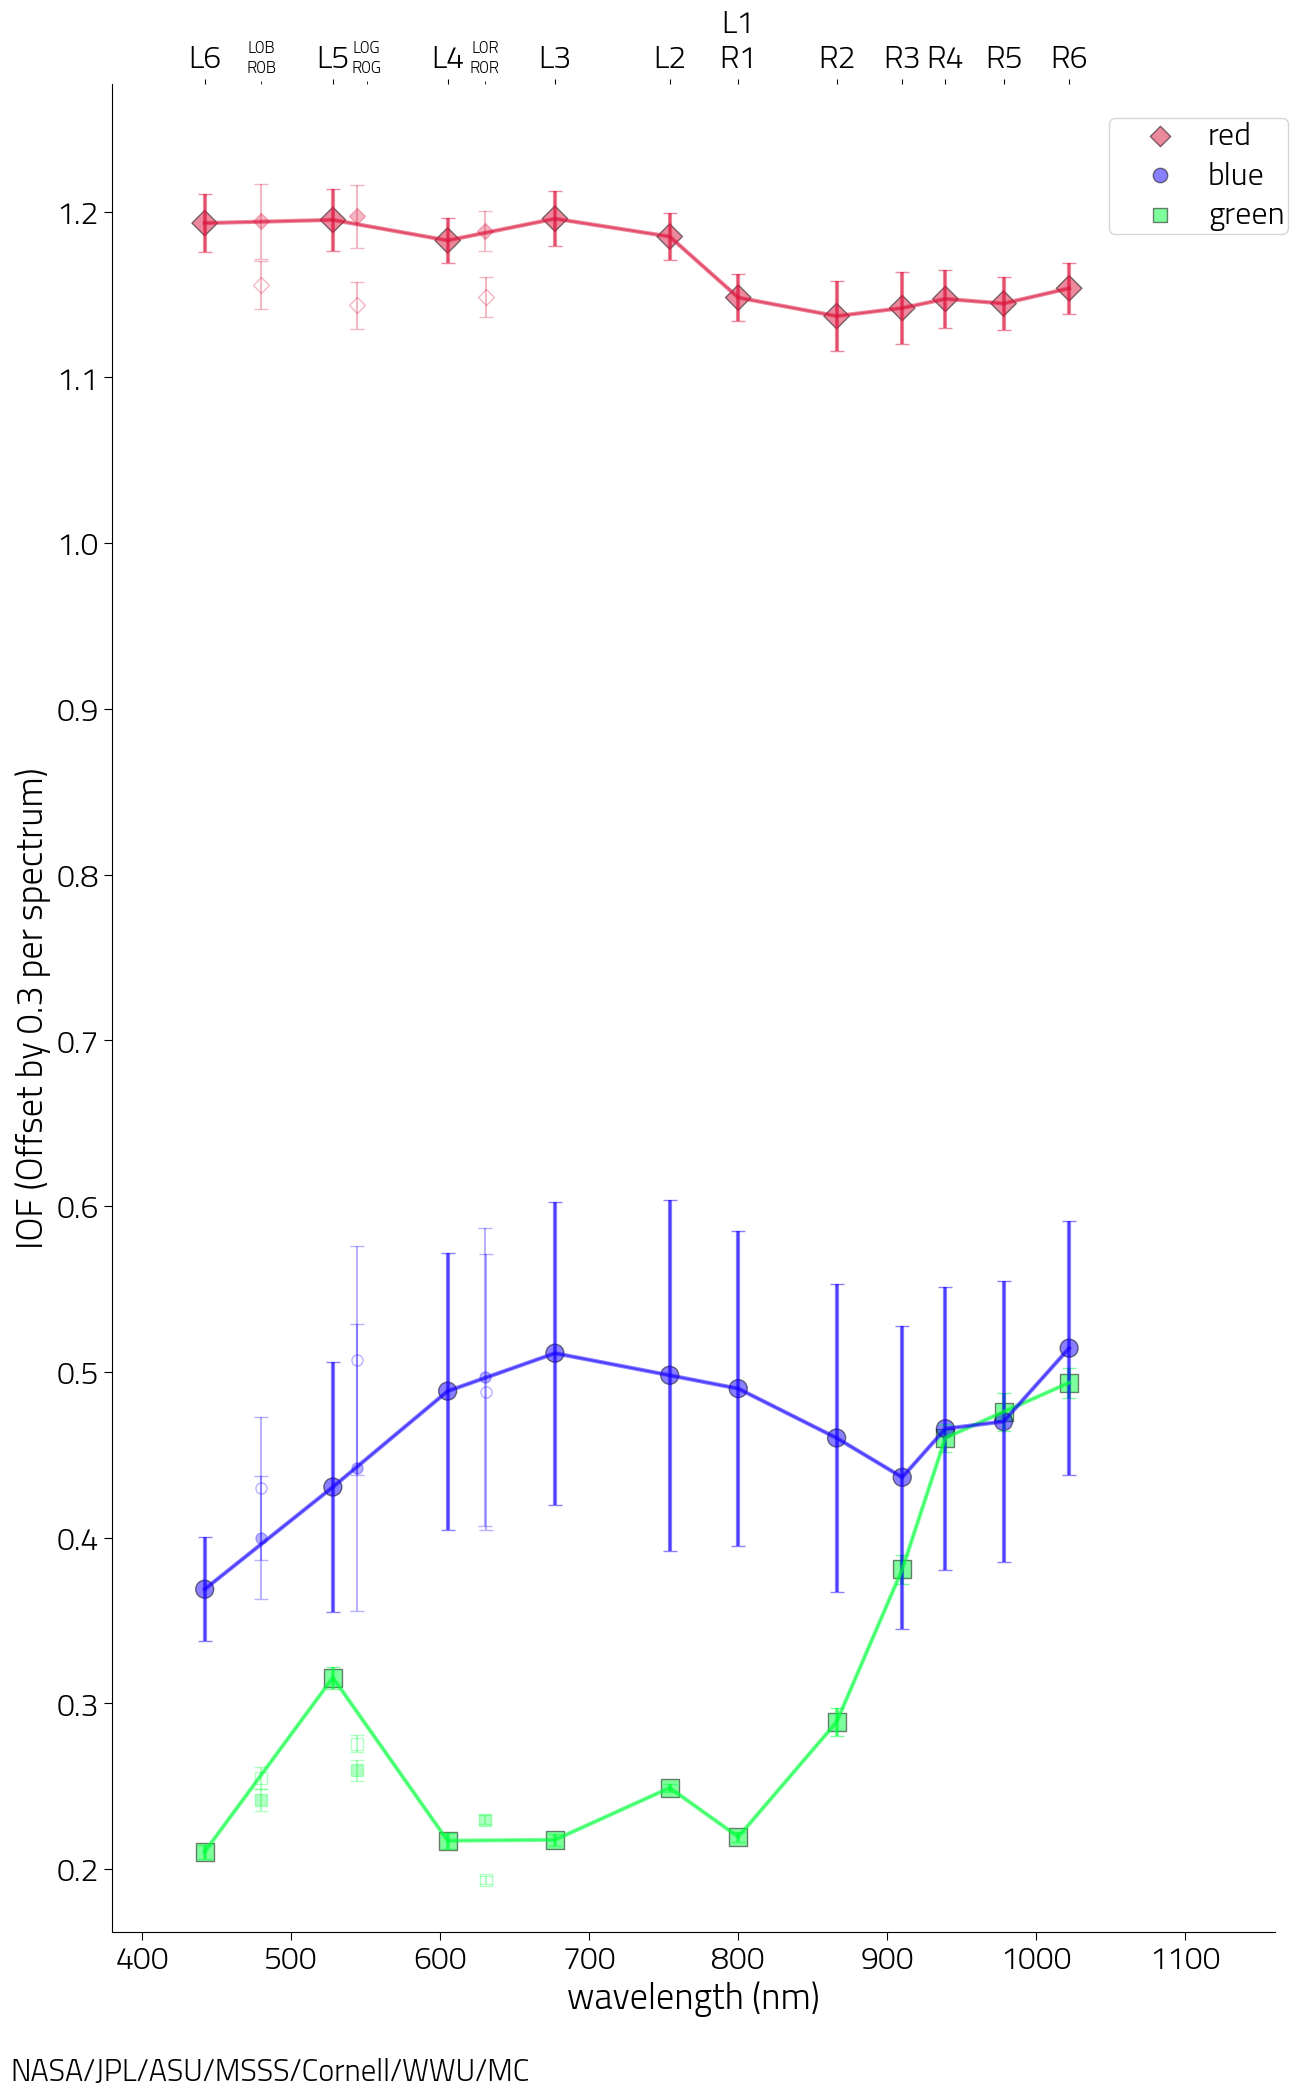

In [8]:
do_pplot(marslab_file, offset=0.3, height_sf=2)

If you'd like to plot your spectra using a different program (like ENVI) to match with other figures you may find `convert_to_simple_format` useful. It will write a csv file from a marslab file in Merspect-like output. Be aware, if you are using multiple marslab files that you'll either need to run this function for each file, or you'll need to change the names in the COLOR column of your marslab files to make sure each is unique.

This function is for convenience of working with other software (not within the Million Concepts purview) we will not be expanding its features or providing additional support.

In [9]:
from pretty_plot.convert import convert_to_simple_format

marslab_file_to_convert = 'pretty_plot/data/zcam/fakeIOFspectra-marslab.csv' 

convert_to_simple_format(marslab_file_to_convert)

Writing pretty_plot/data/zcam/fakeIOFspectra-simplified.csv


,Wavelength (nm),Eye,green_mean,green_err,blue_mean,blue_err,red_mean,red_err
0,1022,RIGHT,0.493447,0.008954,0.214306,0.076812,0.553821,0.015427
1,978,RIGHT,0.475872,0.011458,0.170030,0.085018,0.544638,0.015866
2,939,RIGHT,0.460198,0.008344,0.165718,0.085224,0.547418,0.017329
3,910,RIGHT,0.380791,0.008530,0.136374,0.091430,0.541906,0.021456
4,866,RIGHT,0.288745,0.008226,0.160098,0.092987,0.537048,0.021199
5,800,LEFT,0.219416,0.002962,0.189889,0.095180,0.548206,0.014259
6,800,RIGHT,0.219416,0.002212,0.189889,0.094479,0.548206,0.015740
7,754,LEFT,0.249012,0.002603,0.197929,0.105833,0.585025,0.014195
8,677,LEFT,0.217635,0.003753,0.211238,0.091555,0.595819,0.016630
9,631,RIGHT,0.193483,0.002559,0.187630,0.083313,0.548309,0.012046


The contents of this repo are provided by the Western Washington University Reflectance Lab (PI: M. Rice) and Million Concepts (C. Million, M. St. Clair, S.V. Brown) under a BSD 3-Clause License. You may do nearly anything that you want with this code. If you have any questions, leave us a Github Issue.